In [25]:
import cellular_automata as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
def simulate_tumor_growth(time_delay, generations, rows, cols, phi, rho, k1, k2, k3, k4, cancer_init_positions, origin):
    history = {}
    M = ca.initialize_grid(rows, cols, cancer_init_positions)

    for g in range(generations):
        M = ca.simulate_tumor_growth_one_step(M, g, time_delay, history, phi, rho, k1, k2, k3, k4, origin, rows, cols)

    return history


In [3]:
generations = 400
ROWS = COLS = 101
ORIGIN = (COLS // 2, ROWS // 2)
PHI = 1000
CANCER_INIT_POSITIONS = [(ORIGIN[0], ORIGIN[1]), (ORIGIN[0] + 1, ORIGIN[1]), 
                         (ORIGIN[0] - 1, ORIGIN[1]), (ORIGIN[0], ORIGIN[1] - 1), 
                         (ORIGIN[0], ORIGIN[1] + 1)]
K1, K2, K3, K4 = 0.74, 0.2, 0.4, 0.4
RHO = 3.85

In [4]:
# time delay = 7
history_delay = simulate_tumor_growth(15, generations, ROWS, COLS, PHI, RHO, K1, K2, K3, K4, CANCER_INIT_POSITIONS, ORIGIN)

In [26]:
# Parameters for the simulation
tau_values = np.linspace(20, 60, 40)  # Range of tau values to simulate
all_critical_points = []  # List to hold lists of critical points for each tau

# Run the simulation for each value of tau and find the critical points
for tau in tau_values:
    time_series = simulate_tumor_growth(tau, generations, ROWS, COLS, PHI, RHO, K1, K2, K3, K4, CANCER_INIT_POSITIONS, ORIGIN)  
    time_series = np.array([time_series[g]['Nc'] for g in range(generations)])
    peaks_max, _ = find_peaks(time_series)  # Detect peaks
    peaks_min, _ = find_peaks(-time_series)  # Detect peaks
    peaks = np.concatenate((peaks_max, peaks_min))
    cp = [time_series[pks] for pks in peaks]  # Get the critical values at the peaks
    # Store the mean of the critical values, or however you define the critical points
    all_critical_points.append(cp)

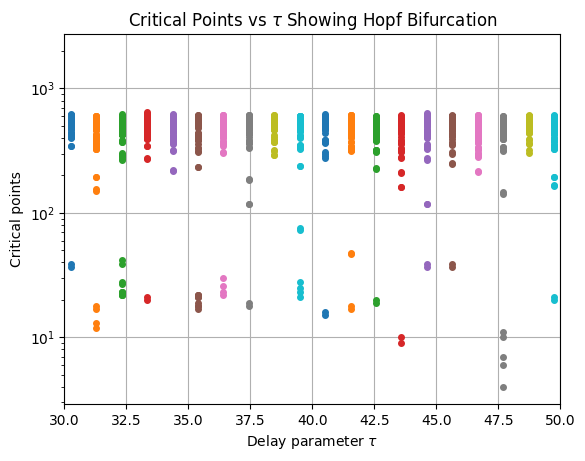

In [27]:
# We will plot each set of critical points for each tau
for idx, tau in enumerate(tau_values):
    critical_points = all_critical_points[idx]
    # Plot each critical point for this tau value
    plt.plot([tau] * len(critical_points), critical_points, 'o', markersize=4)

plt.xlabel('Delay parameter $\\tau$')
plt.ylabel('Critical points')
# plt.ylim(0,700)
plt.yscale('log')
plt.xlim(30,50)
plt.title('Critical Points vs $\\tau$ Showing Hopf Bifurcation')
plt.grid(True)
plt.show()

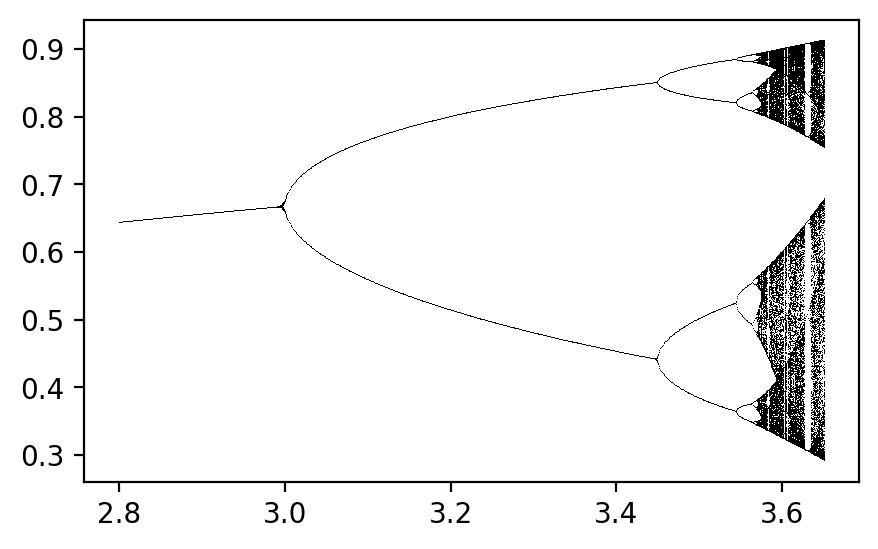

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
     
@numba.jit(nopython=True, parallel=True)
def calc():
  min_r = 2.8
  max_r = 3.65
  step_r = 0.001
  max_iterations = 1000
  skip_iterations = 500
  max_counter = int((max_iterations - skip_iterations) * (max_r - min_r) / step_r)
  result_x = np.zeros(max_counter)
  result_r = np.zeros(max_counter)
  i = 0
  for r in np.arange(min_r, max_r, step_r):
    x = 0.1
    for it in range(max_iterations):
      x = r * x * (1-x)
      if it > skip_iterations:
        result_x[i] = x
        result_r[i] = r
        i += 1
  result_x = result_x[result_r != 0].copy()
  result_r = result_r[result_r != 0].copy()
  return result_x, result_r

result_x, result_r = calc()
     

plt.figure(figsize=(5, 3), dpi=200)
plt.plot(result_r, result_x, ",", color='k')
plt.show()
     